# Flocks, Herds, and Traffic Jams

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 10

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [2]:
import vpython

from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import thinkplot
from thinkstats2 import RandomSeed

from Cell2D import Cell2DViewer

from matplotlib import rc
rc('animation', html='html5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
class Driver:
    
    def __init__(self, loc, speed=4):
        """Initialize the attributes.
        
        loc: position on track, in miles
        speed: speed in miles per hour
        """
        self.start = loc
        self.loc = loc
        self.speed = speed
        
    def choose_acceleration(self, d):
        return 1
        
    def set_odometer(self):
        self.start = self.loc
        
    def read_odometer(self):
        return self.loc - self.start

In [3]:
class Highway:
    
    max_acc = 1
    min_acc = -10
    speed_limit = 40
    
    def __init__(self, n=10, length=1000, eps=0, constructor=Driver):
        """Initializes the attributes.
        
        n: number of drivers
        length: length of the track
        eps: variability in speed
        constructor: function used to instantiate drivers
        """
        self.length = length
        self.eps = eps
        self.crashes = 0

        # create the drivers
        locs = np.linspace(0, length, n, endpoint=False)
        self.drivers = [constructor(loc) for loc in locs]
        
        # and link them up
        for i in range(n):
            j = (i+1) % n
            self.drivers[i].next = self.drivers[j]
            
    def step(self):
        """Performs one time step."""
        for driver in self.drivers:
            self.move(driver)
            
    def move(self, driver):
        """Updates `driver`.
        
        driver: Driver object
        """
        # get the distance to the next driver
        d = self.distance(driver)

        # let the driver choose acceleration
        acc = driver.choose_acceleration(d)
        acc = min(acc, self.max_acc)
        acc = max(acc, self.min_acc)
        speed = driver.speed + acc
            
        # add random noise to speed
        speed *= np.random.uniform(1-self.eps, 1+self.eps)
        
        # keep it nonnegative and under the speed limit
        speed = max(speed, 0)
        speed = min(speed, self.speed_limit)
        
        # if current speed would collide with next driver, stop
        if speed > d:
            speed = 0
            self.crashes += 1
            
        # update speed and loc
        driver.speed = speed
        driver.loc += speed
            
    def distance(self, driver):
        """Distance from `driver` to next driver.
        
        driver: Driver object
        """
        d = driver.next.loc - driver.loc
        # fix wraparound
        if d < 0:
            d += self.length
        return d
    
    def set_odometers(self):
        return [driver.set_odometer()
                for driver in self.drivers] 
    
    def read_odometers(self):
        return np.mean([driver.read_odometer()
                        for driver in self.drivers])

In [4]:
class HighwayViewer(Cell2DViewer):
    """Generates visualization and animation of SugarScape."""
    
    def draw(self, grid=False):
        """Draws the array and any other elements.
        
        grid: boolean, whether to draw grid lines
        """
        self.draw_drivers()
        
        plt.axis('off')
        plt.axis('equal')
        plt.xlim([-1.05, 1.05])
        plt.ylim([-1.05, 1.05])

    def draw_drivers(self):
        """Plots the drivers.
        """
        drivers = self.viewee.drivers
        xs, ys = self.get_coords(drivers)
        self.points = plt.plot(xs, ys, '.', color='blue', markersize=20)[0]
        
        stopped = [driver for driver in self.viewee.drivers 
                  if driver.speed==0]
        xs, ys = self.get_coords(stopped)
        xs *= 0.9
        ys *= 0.9
        self.stopped = plt.plot(xs, ys, 'x', color='red')[0]
        
    def animate_func(self, i):
        """Draws one frame of the animation."""
        if i > 0:
            self.step()
        drivers = self.viewee.drivers
        xs, ys = self.get_coords(drivers)
        self.points.set_data(np.array([xs, ys]))
        
        stopped = [driver for driver in self.viewee.drivers 
                  if driver.speed==0]
        xs, ys = self.get_coords(stopped)
        self.stopped.set_data(np.array([xs, ys]) * 0.9)
        return self.points,
    
    def get_coords(self, drivers):
        """Gets the coordinates of the drivers.
        
        Transforms from (row, col) to (x, y).
        
        returns: tuple of sequences, (xs, ys)
        """
        scale = 2 * np.pi / self.viewee.length
        
        locs = np.array([driver.loc for driver in drivers])
        xs = np.cos(locs * scale)
        ys = np.sin(locs * scale)
        return xs, ys

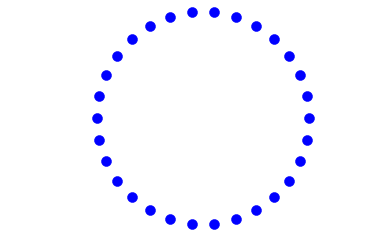

In [5]:
highway = Highway(30, eps=0.02)
viewer = HighwayViewer(highway)
anim = viewer.animate(frames=600, interval=200)

In [6]:
anim

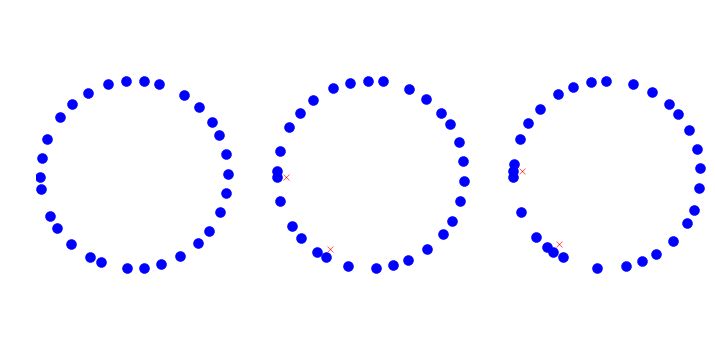

In [18]:
RandomSeed(22)

highway = Highway(30, eps=0.02)
viewer = HighwayViewer(highway)

thinkplot.preplot(cols=3)
for i in range(16):
    highway.step()
viewer.draw()

thinkplot.subplot(2)
for i in range(1):
    highway.step()
viewer.draw()

thinkplot.subplot(3)
for i in range(1):
    highway.step()
viewer.draw()

plt.savefig('chap10-1.pdf')

In [8]:
def run_simulation(eps, constructor=Driver, iters=100):
    res = []
    for n in range(5, 100, 5):
        highway = Highway(n, eps=eps, constructor=constructor)
        for i in range(iters):
            highway.step()

        highway.set_odometers()
        for i in range(iters):
            highway.step()

        res.append((n, highway.read_odometers() / iters))
    
    return np.transpose(res)

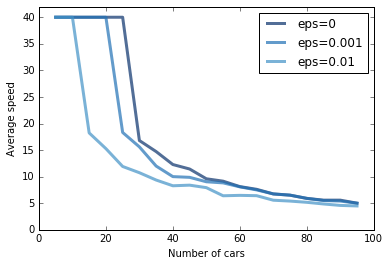

In [19]:
RandomSeed(20)

for eps in [0.0, 0.001, 0.01]:
    xs, ys = run_simulation(eps)
    thinkplot.plot(xs, ys, label='eps=%g' % eps)
    
thinkplot.config(xlabel='Number of cars',
                 ylabel='Average speed',
                 xlim=[0, 100], ylim=[0, 42])

plt.savefig('chap10-2.pdf')

**Exercise:**

In [10]:
class BetterDriver(Driver):
    def choose_acceleration(self, d):
        if self.speed < 20:
            return 1
        else:
            return 0

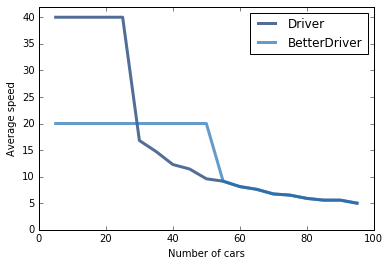

In [11]:
for constructor in [Driver, BetterDriver]:
    xs, ys = run_simulation(eps=0.0, constructor=constructor)
    thinkplot.plot(xs, ys, label=constructor.__name__)
    
thinkplot.config(xlabel='Number of cars',
                 ylabel='Average speed',
                 xlim=[0, 100], ylim=[0, 42])

## Boids

In [12]:
# size of the boids
b_radius = 0.03
b_length = 0.1

# radii for sensing different rules
r_avoid = 0.3
r_center = 1.0
r_copy = 0.5

# viewing angle for different rules, in radians
a_avoid = 2*np.pi
a_center = 2
a_copy = 2

# weights for various rules
w_avoid = 4
w_center = 3
w_copy = 2
w_love = 10

# time step
dt = 0.1


In [13]:
def random_vector(a, b):
    """Create a vector with each element uniformly distributed in [a, b)."""
    t = [np.random.uniform(a,b) for i in range(3)]
    return vpython.vector(*t)


def limit_vector(vect):
    """if the magnitude is greater than 1, set it to 1"""
    if vect.mag > 1:
        vect.mag = 1
    return vect


null_vector = vpython.vector(0,0,0)

In [14]:
random_vector(0, 6)

<4.580966, 4.231991, 3.634073>

In [15]:
class Boid(vpython.cone):
    """A Boid is a VPython cone with a velocity"""

    def __init__(self, radius=b_radius, length=b_length):
        pos = random_vector(0, 1)
        self.vel = random_vector(0, 1).norm()
        vpython.cone.__init__(self, pos=pos, radius=radius)
        self.axis = length * self.vel.norm()

    def get_neighbors(self, others, radius, angle):
        """Return the list of neighbors within the given radius and angle."""
        boids = []
        for other in others:
            if other is self: continue
            offset = other.pos - self.pos
            
            # if not in range, skip it
            if offset.mag > radius: 
                continue

            # if not within viewing angle, skip it
            if self.vel.diff_angle(offset) > angle:
                continue

            # otherwise add it to the list
            boids.append(other)
            
        return boids

    def avoid(self, others, carrot):
        """Find the center of mass of all objects in range and
        returns a vector in the opposite direction, with magnitude
        proportional to the inverse of the distance (up to a limit)."""
        others = others + [carrot]
        close = self.get_neighbors(others, r_avoid, a_avoid)
        t = [other.pos for other in close]
        if t:
            center = np.sum(t)/len(t)
            away = vpython.vector(self.pos - center)
            away.mag = r_avoid / away.mag
            return limit_vector(away)
        else:
            return null_vector

    def center(self, others):
        """Find the center of mass of other boids in range and
        returns a vector pointing toward it."""
        close = self.get_neighbors(others, r_center, a_center)
        t = [other.pos for other in close]
        if t:
            center = np.sum(t)/len(t)
            toward = vpython.vector(center - self.pos)
            return limit_vector(toward)
        else:
            return null_vector

    def copy(self, others):
        """Return the average heading of other boids in range.
        
        others: list of Boids
        """
        close = self.get_neighbors(others, r_copy, a_copy)
        t = [other.vel for other in close]
        if t:
            # TODO: replace this with mean
            center = np.sum(t)/len(t)
            away = vpython.vector(self.pos - center)
            return limit_vector(away)
        else:
            return null_vector

    def love(self, carrot):
        """Returns a vector pointing toward the carrot."""
        toward = carrot.pos - self.pos
        return limit_vector(toward)

    def set_goal(self, boids, carrot):
        """Sets the goal to be the weighted sum of the goal vectors."""
        self.goal = (w_avoid * self.avoid(boids, carrot) + 
                     w_center * self.center(boids) +
                     w_copy * self.copy(boids) + 
                     w_love * self.love(carrot))
        self.goal.mag = 1
        
    def move(self, mu=0.1):
        """Update the velocity, position and axis vectors.
        mu controls how fast the boids can turn (maneuverability)."""

        self.vel = (1-mu) * self.vel + mu * self.goal
        self.vel.mag = 1

        self.pos += dt * self.vel
        self.axis = b_length * self.vel.norm()
        


In [16]:
class World(object):
    
    def __init__(self, n=10):
        """Create n Boids and one carrot.

        tracking: indicates whether the carrot follows the mouse
        """
        self.boids = [Boid() for i in range(n)]
        vec = vpython.vector
        self.carrot = vpython.sphere(pos=vec(1,0,0), radius=0.1, color=vec(1,0,0))
        print(self.carrot)
        self.tracking = False
        
    def step(self):
        """Compute one time step."""
        # move the boids
        for boid in self.boids:
            boid.set_goal(self.boids, self.carrot)
            boid.move()

        # mouse click toggles tracking
        if canvas.mouse.clicked:
            canvas.mouse.getclick()
            self.tracking = not self.tracking

        # if we're tracking, move the carrot
        if self.tracking:
            self.carrot.pos = canvas.mouse.pos

In [17]:
n = 20
size = 5

# TODO: don't make this a global
canvas = vpython.canvas(title='Boids', width=800, height=600,
                           range=(size, size, size))
print(canvas)

world = World(n)
canvas.center = world.carrot.pos
canvas.autoscale = False

while 1:
    # update the screen once per time step
    vpython.rate(1/dt)
    world.step()

<IPython.core.display.Javascript object>

AttributeError: 'Mouse' object has no attribute 'clicked'